In [508]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.feature_selection import SelectKBest, mutual_info_classif


# Cleaning

In [509]:
df = pd.read_csv('critical_mention_report_2023-02-17.csv')
date_format = "%b %d, %Y %I:%M %p %Z"

In [510]:
#Cleaning Data
df = df.dropna(axis=1, how='all')

df = df.drop(['Online + Print Source Page', 'Text', 'URL', 'Last Updated', 'Text ID', 'Thumbnail', 'Clip ID', 'License Name', 'Copyright'], axis=1)

#for exporting cleaned data
def export_dropna(df):
    df.to_csv('score_data_cleaned.csv', index=False)
#export_dropna(df)


In [511]:
#Making the Dates Datetime objects
date_format_1 = '%m/%d/%Y %I:%M:%S %p'
date_format_2 = '%I:%M %p'

# Define a function to convert a single time string to a datetime object, removing 'CDT'
def convert_time_string(time_str):
    # Remove the last 4 characters (' CDT') from the time string
    time_str = time_str[:-4]
    
    # Parse the time string to a datetime object without timezone information
    datetime_obj = datetime.strptime(time_str, date_format_2)
    
    return datetime_obj

# Apply the function to the 'time_str' column to create a new 'datetime' column
df['Broadcast Time'] = df['Broadcast Time'].apply(convert_time_string)


df['Date and Time'] = df['Time Clip'].apply(lambda x: datetime.strptime(x, date_format_1))

In [512]:
#Getting rid of Local Audience and Publicity Value, after talking to Lori she said that these were not necesssary since 1/4 of the data did not exist

df.groupby('Estimated Local Audience').size() # 2595 values that are zero
df.groupby('Estimated Local Publicity Value').size()
len(df) #8292 total values

df = df.drop(['Estimated Local Audience', 'Estimated Local Publicity Value'], axis=1)


# Dissecting Different types of Press Content

In [513]:
df['Press Content'] = pd.Series([[]] * len(df))
df['Keywords'] = df['Keywords'].astype(str)

# Ask SCORE

In [514]:
#Checks for 'ASK SCORE' or 'Business Tips from SCORE' in title
def add_ask_score(title):
    if isinstance(title, str) and ('ask score' in title.lower() or 'business tips from score' in title.lower()):
        return True
    else:
        return False
    
ask_score_authors = ['Marc Goldberg',
                     'Dean Swanson', 'Steve Wolfson', 'Gray Poehler',
                     'Bill Nordbrock', 'Ken Sethney', 'Tina Dettman-Bielefeldt', 'Susan Chandler', 
                     'Harvey Mackay']

ask_score_authors = [x.lower() for x in ask_score_authors]

#Checks if one of the common ask score authors wrote the article
def add_ask_score_authors(author):
    if isinstance(author, str) and author.lower() in ask_score_authors:
        return True
    else:
        return False

title = df['Article Title'].apply(lambda x: add_ask_score(x))
authors = df['Online + Print Author'].apply(lambda x: add_ask_score_authors(x))

df['Ask SCORE'] = title | authors

df.groupby('Ask SCORE').size()


Ask SCORE
False    8102
True      190
dtype: int64

# Radio PSA

In [515]:
#The Radio PSAs were outlined as Radio in Media Type. 
def add_radio(x):
    if x == 'RADIO':
        return True
    else:
        return False
    
df['Radio PSA'] = df['Media Type'].apply(lambda x: add_radio(x))

df.groupby('Radio PSA').size()

Radio PSA
False    5768
True     2524
dtype: int64

# Press Release

In [516]:
#Press Releases have 'Press' in the Online + Print Source Name, so I filtered for that when trying to find out which ones were in this category
def add_press_release(x):
    if isinstance(x, str) and 'Press' in x:
        return True
    else:
        return False
    
df['Press Release'] = df['Online + Print Source Name'].apply(lambda x: add_press_release(x))

df.groupby('Press Release').size()

Press Release
False    8100
True      192
dtype: int64

# Local Chapter Workshops

In [517]:
#Filtered the Text description of the clip to see if it related to a workshop of some kind
def add_chapter_workshops(text):
    if 'workshops' in text.lower():
        return True
    else:
        return False
    
df['Local Chapter Workshops'] = df['Plain Text'].apply(lambda x: add_chapter_workshops(x))

df.groupby('Local Chapter Workshops').size()

Local Chapter Workshops
False    7622
True      670
dtype: int64

# Success Stories

In [518]:
success_story_busineses = ['Aclipse Campervans', 'Alliance Historical Society', 'Anchor Hoist', 'AR\'s Hot Southern Honey', 'ArtRoom Flowers', 'Bal Arisi', 'The Barn Yard', 'Be Moore Interpreting', 'BHA Consulting', 'Bixby Chocolate', 'Bounce Around Bucks Party Rentals', 'Cafe la Reine', 'Cleveland Flower Walls', 'Crossfire Fitness', 'Firefly Landing Cafe and Bakery', 'The Flossy Peach', 'Flourish Plant Market', 'FrostyFlake', 'Giuliano\'s Deli', 'Gluten Free Navigator', 'Go Girl Life Coaching', 'Grass Sticks', 'Healthy Home Organizing', 'Healthy PlanEat', 'Hope and Meaning Counseling', 'Ice Imports', 'Inspired Wraps', 'Julia Piechota - Life Coach', 'K9 Solutions', 'Kona Compost Owner', 'Las Cruces Coins & Collectibles', 'Leo\'s Mercado', 'Lorton\'s Victor Wear', 'Love & Envy', 'Mixtape Streets Eatery', 'Nature Packaged', 'NOLA Coffee', 'Ohhs Disposable Underwear', 'Owl Arts', 'Pieh Tool Company', 'Ray of Light Offerings', 'RiverFire Glass', 'School Food Service Solutions, LLC', 'SIC Wraps', 'Sound Bites Nutrition', 'SURE!', 'The Sensory Club', 'Thompson Tee', 'Tredge Solutions', 'Uni Uni', 'Union Yoga Co', 'Waggin Trails LLC', 'Warminster Wellness', 'Whitson Wonder Productions', 'Wing Tsun Illinois', 'Veterans 1st of NEW', 'Victor Wear']

success_story_busineses = [x.lower() for x in success_story_busineses]

#Filtered to see if Success Story businesses were mentioned
def add_success_stories(text):
    for business in success_story_busineses:
        if business in text.lower():
            return True 
    return False

df['Success Stories'] = df['Plain Text'].apply(lambda x: add_success_stories(x))

df.groupby('Success Stories').size()


Success Stories
False    8165
True      127
dtype: int64

# Pitch Placements

In [519]:
pitch_authors = ['Aaron Mulherin', 'Ames Russell', 'Billy Thompson', 
                 'Candice Stennett', 'Carolyn Katz', 'DeLisa Clift', 
                 'Dina Estrada', 'Evelyn Shields', 'Fanni Xie', 
                 'Fernando Nunez', 'Frank LaMonaca', 'Gary Robinson', 
                 'Hal Shelton', 'Jay Berman', 'Jenna Tucker', 'Judy Trevino', 'Julie Brander', 'Kate McAleer', 'Kelly Twichel', 
                 'Laura Licursi', 'Leland Dear', 'Lenny Buchholtz', 
                 'Lori Martinek', 'Lorinda Gonzalez', 
                 'Mark Cutler', 'Matt Evans', 'Nicole Ehrbar', 'Norm Sherman',
                 'Patrick Hall', 'Patti Williams', 'Raj Tumber', 
                 'Rani Martier', 'Ricardo Casas', 'Steven Cybulski', 'Tara Ritchie', 'Walter Abbott', 'Bridget Weston', 'Betsy Dougert']

pitch_authors = [x.lower() for x in pitch_authors]

pitch_keywords = ['Megaphone of Main Street','SCORE data','SCORE mentor']
pitch_keywords = [x.lower() for x in pitch_keywords]

# Filtered to see if there was a pitch placement author who wrote the clip, or a pitch placement keyword was used
def add_pitch_placements(text):
    for author in pitch_authors:
        if author in text.lower():
            return True 
    for keyword in pitch_keywords:
        if keyword in text.lower():
            return True       
    return False


df['Pitch Placements'] = df['Plain Text'].apply(lambda x: add_pitch_placements(x))


df.groupby('Pitch Placements').size()


Pitch Placements
False     102
True     8190
dtype: int64

# Charts

In [520]:
charts = pd.DataFrame()

# Titles
charts['Press Content'] = ['Ask SCORE', 'Radio PSA', 'Press Release', 'Local Chapter Workshops', 'Success Stories', 'Pitch Placements']

# Total Entries
charts['Total Entries'] = 0
for i in range(len(charts)):
    press_content = charts.loc[i, 'Press Content']
    charts.at[i, 'Total Entries'] = (df[press_content] == True).sum()

# Average Estimated National Audience
charts['Average Estimated National Audience'] = np.nan
for i in range(len(charts)):
    press_content = charts.loc[i, 'Press Content']
    mask = df[press_content] == True
    charts.at[i, 'Average Estimated National Audience'] = df.loc[mask, 'Estimated National Audience'].mean()

# Average Estimated National Publicity Value
charts['Average Estimated National Publicity Value'] = np.nan
for i in range(len(charts)):
    press_content = charts.loc[i, 'Press Content']
    mask = df[press_content] == True
    charts.at[i, 'Average Estimated National Publicity Value'] = df.loc[mask, 'Estimated National Publicity Value'].mean()

charts



,Press Content,Total Entries,Average Estimated National Audience,Average Estimated National Publicity Value
0,Ask SCORE,190,7.730159e+05,84710.431579
1,Radio PSA,2524,2.800756e+04,86.601030
2,Press Release,192,9.602262e+04,664.770833
3,Local Chapter Workshops,670,3.383512e+05,3068.305970
4,Success Stories,127,1.076787e+06,6654.866142
5,Pitch Placements,8190,5.203982e+05,11751.636264


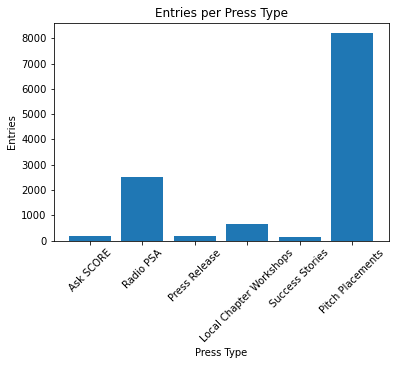

In [521]:
#Total Entries Plot

# Data
x_values = charts['Press Content']
y_values = charts['Total Entries']

# Plotting
plt.bar(x_values, y_values)

# Axis labels
plt.xlabel('Press Type')
plt.ylabel('Entries')

# Title
plt.title('Entries per Press Type')

#So the names do not overlap
plt.xticks(rotation=45)

# Display the plot
plt.show()

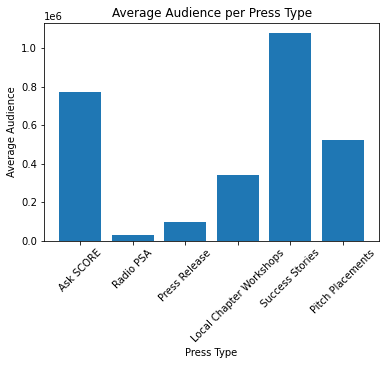

In [522]:
#Average Estimated Audience Plot

# Data
x_values = charts['Press Content']
y_values = charts['Average Estimated National Audience']

# Plotting
plt.bar(x_values, y_values)

# Axis labels
plt.xlabel('Press Type')
plt.ylabel('Average Audience')

# Title
plt.title('Average Audience per Press Type')
plt.xticks(rotation=45)

# Display the plot
plt.show()

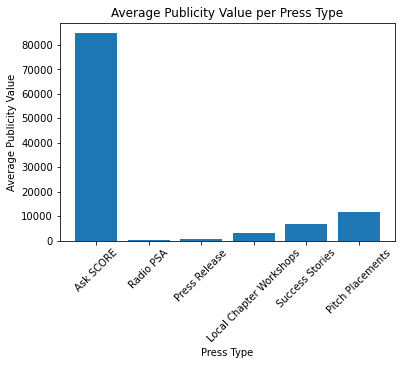

In [523]:
#Total Entries Plot

# Data
x_values = charts['Press Content']
y_values = charts['Average Estimated National Publicity Value']

# Plotting
plt.bar(x_values, y_values)

# Axis labels
plt.xlabel('Press Type')
plt.ylabel('Average Publicity Value')

# Title
plt.title('Average Publicity Value per Press Type')
plt.xticks(rotation=45)

# Display the plot
plt.show()